In [19]:
import pandas as pd
import numpy as np
from joblib import dump, load
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import os
os.environ['LOKY_MAX_CPU_COUNT'] = '4'  # Replace 4 with the number of cores you want to use

# Load the dataset into a DataFrame
df = pd.read_csv(r"C:\Users\USER\OneDrive\Desktop\Cancer Fight\models\data.csv")

# Check for non-numeric columns
print(df.dtypes)

# Drop rows where the target 'diagnosis' is missing
df = df.dropna(subset=['diagnosis'])

# Define target and feature columns
target_col = 'diagnosis'
feature_cols = df.columns.drop(target_col)

# Convert feature columns to numeric (non-convertible values become NaN)
for col in feature_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Fill missing values only in the feature columns
df[feature_cols] = df[feature_cols].fillna(df[feature_cols].mean())


# Extract features (X) and target (y)
X = df.drop(columns=[target_col])
y = df[target_col]

# Convert target variable to binary (if not already 0/1)
y = y.map({'B': 0, 'M': 1})  

# Drop rows where mapping produced NaN (if any unexpected values were present)
non_missing = y.notna()
X = X.loc[non_missing]
y = y.loc[non_missing]

# Remove constant feature columns before splitting/scaling
constant_columns = X.columns[X.nunique() == 1]
if len(constant_columns) > 0:
    print(f"Dropping constant columns: {list(constant_columns)}")
    X = X.drop(columns=constant_columns)

# Drop 'diagnosis' column as it is not part of the features expected by the model
X = X.drop(columns=['diagnosis'], errors='ignore')

# Ensure the feature set is consistent by saving the feature names
feature_names = X.columns.tolist()

# Additional diagnostic checks
print("Shape before cleaning:", df.shape)
print("Columns:", list(df.columns))
print("Unique values in diagnosis:", df['diagnosis'].unique())

# Check for infinite values
print("Columns with infinite values:")
print(df.isin([np.inf, -np.inf]).any())

# Detailed column info
print(df.info())

id                           int64
diagnosis                   object
radius_mean                float64
texture_mean               float64
perimeter_mean             float64
area_mean                  float64
smoothness_mean            float64
compactness_mean           float64
concavity_mean             float64
concave points_mean        float64
symmetry_mean              float64
fractal_dimension_mean     float64
radius_se                  float64
texture_se                 float64
perimeter_se               float64
area_se                    float64
smoothness_se              float64
compactness_se             float64
concavity_se               float64
concave points_se          float64
symmetry_se                float64
fractal_dimension_se       float64
radius_worst               float64
texture_worst              float64
perimeter_worst            float64
area_worst                 float64
smoothness_worst           float64
compactness_worst          float64
concavity_worst     

c:\Users\USER\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
c:\Users\USER\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
c:\Users\USER\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


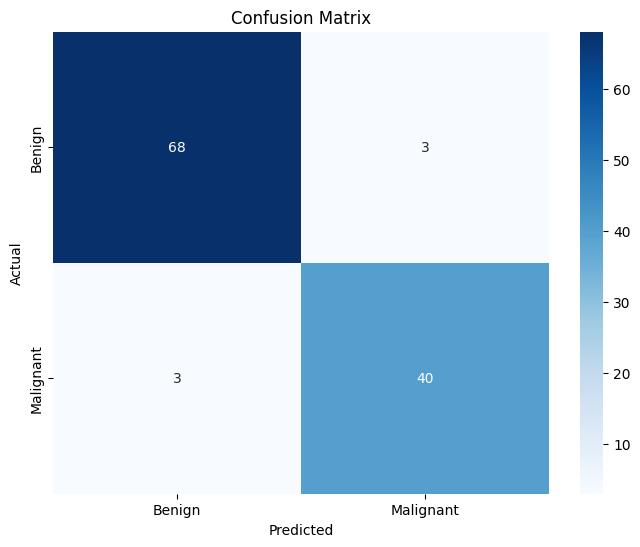

In [20]:
import seaborn as sns


# Split the dataset into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Ensure no missing values in the training and testing sets after scaling
X_train = np.nan_to_num(X_train)
X_test = np.nan_to_num(X_test)

# Train the KNN Classifier
knn = KNeighborsClassifier(n_neighbors=5)  # k=5 as default
knn.fit(X_train, y_train)

# Make predictions
y_pred = knn.predict(X_test)
# Visualize the confusion matrix
import matplotlib.pyplot as plt

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Note: KNN does not provide feature importance directly.
# If feature importance is required, we consider using a different model like RandomForestClassifier.

Accuracy: 0.9473684210526315
Precision: 0.9302325581395349
Recall: 0.9302325581395349
F1 Score: 0.9302325581395349
Confusion Matrix:
 [[68  3]
 [ 3 40]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96        71
           1       0.93      0.93      0.93        43

    accuracy                           0.95       114
   macro avg       0.94      0.94      0.94       114
weighted avg       0.95      0.95      0.95       114



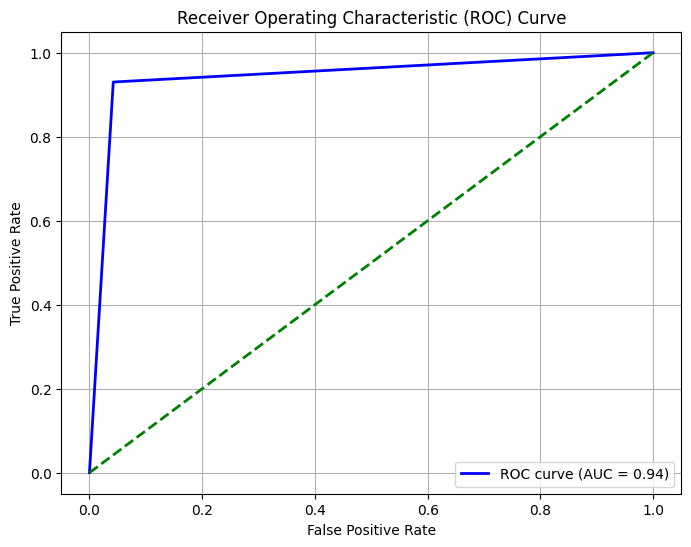

In [21]:
from sklearn.metrics import roc_curve, auc



# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", classification_report(y_test, y_pred))
# Visualize the ROC curve

# Compute the ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='green', linestyle='--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [22]:
# Saving the model
dump(knn, 'model.joblib')

# Loading the model
loaded_model = load('model.joblib')

# Save feature names
dump(feature_names, 'feature_names.joblib')

# Save the scalar
dump(scaler, 'scaler.joblib')

# Load the scalar
loaded_scaler = load('scaler.joblib')